In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rec-system/Project 2/item_properties_combined.csv
/kaggle/input/rec-system/Project 2/category_tree.csv
/kaggle/input/rec-system/Project 2/events.csv


In [2]:
!pip install lightgbm

In [3]:
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from collections import Counter
import plotly.express as px

In [4]:
def clean_value(val):
    """
    Clean 'value' field from item properties:
    - Converts 'n123.000' -> 123.0 (float)
    - Converts 'n-3.675' -> -3.675 (float)
    - Converts plain integers to int
    - Leaves text tokens unchanged
    - Joins multiple tokens back into a single string (space-separated)
    """
    if not isinstance(val, str):
        return val
    
    cleaned_tokens = []
    for token in val.split():
        if token.startswith("n"):
            try:
                cleaned_tokens.append(str(float(token[1:])))  # normalize numeric tokens
            except ValueError:
                cleaned_tokens.append(token)
        else:
            try:
                cleaned_tokens.append(str(int(token)))  # keep as int but convert to str
            except ValueError:
                cleaned_tokens.append(token)
    
    return " ".join(cleaned_tokens)  # always return a string


In [5]:
# =============================================
# Data Cleaning + Save Cleaned Files
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import plotly.express as px

# -----------------------
import pandas as pd

# -----------------------
# Step 1: Load raw datasets

# Load events
events = pd.read_csv('/kaggle/input/rec-system/Project 2/events.csv')

# Load and clean item_properties
item_props = pd.read_csv('/kaggle/input/rec-system/Project 2/item_properties_combined.csv',
                         names=["timestamp", "itemid", "property", "value"],
                         skiprows=1)  # Skip the header row
item_props["value"] = item_props["value"].apply(clean_value)

# Load category_tree
category_tree = pd.read_csv('/kaggle/input/rec-system/Project 2/category_tree.csv',
                            names=["child", "parent"],
                            skiprows=1)  # also skip header row if needed

print(f"Events shape: {events.shape}")
print(f"Item properties shape: {item_props.shape}")
print(f"Category tree shape: {category_tree.shape}")


# Converting Events timestamp to datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')


# Remove rows where property is "available" or "categoryid"
item_props = item_props[~item_props["property"].isin(["available", "categoryid"])]
print(f"Dataset shape after removal: {item_props.shape}")
print(item_props["property"].value_counts().head(10))

# Print dataset shapes
print("Initial shapes:")
print(f"Events: {events.shape}")
print(f"Item Properties: {item_props.shape}")
print(f"Category Tree: {category_tree.shape}")



Events shape: (2756101, 5)
Item properties shape: (9623154, 4)
Category tree shape: (1669, 2)
Dataset shape after removal: (8535899, 4)
property
888    1424935
790     848982
6       299890
283     283242
776     272834
678     229066
364     224396
202     212686
839     198356
159     198157
Name: count, dtype: int64
Initial shapes:
Events: (2756101, 5)
Item Properties: (8535899, 4)
Category Tree: (1669, 2)


In [6]:
# -----------------------
# Step 2: Clean abnormal values
# -----------------------

# Convert timestamp to datetime
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")
events = events.dropna(subset=["timestamp"])
events = events[(events["timestamp"] >= "2014-01-01") & (events["timestamp"] <= "2016-12-31")]

# Remove null critical fields & invalid events
events = events.dropna(subset=["visitorid", "event", "itemid"])
events = events[events["event"].isin(["view", "addtocart", "transaction"])]

# Clean numeric-looking property values in item_properties
def clean_numeric(val):
    if isinstance(val, str) and val.startswith("n"):
        try:
            return float(val[1:])
        except:
            return np.nan
    return val

item_props["value"] = item_props["value"].apply(clean_numeric)
item_props = item_props.dropna(subset=["itemid", "property", "value"])

# Remove duplicate category entries
# category_tree = category_tree.drop_duplicates()

# -----------------------
# Step 3: Outlier detection (abnormal users)
# -----------------------
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

def build_user_features(events_df):
    # Handle empty input
    if events_df.empty:
        return pd.DataFrame(
            columns=["visitorid", "total_events", "views", "adds", "buys", "add_rate", "conv_rate"]
        ).set_index("visitorid")

    feats = []
    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

# Build user features
user_feats = build_user_features(events)

# Outlier detection
if not user_feats.empty:
    iso = IsolationForest(contamination=0.02, random_state=42)
    user_feats["outlier"] = (iso.fit_predict(user_feats) == -1).astype(int)
    outlier_users = user_feats[user_feats["outlier"] == 1].index
    events = events[~events["visitorid"].isin(outlier_users)]
    print(f"Removed {len(outlier_users)} abnormal users.")
else:
    print("No user features to build after cleaning. Skipping outlier detection.")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Removed 27190 abnormal users.


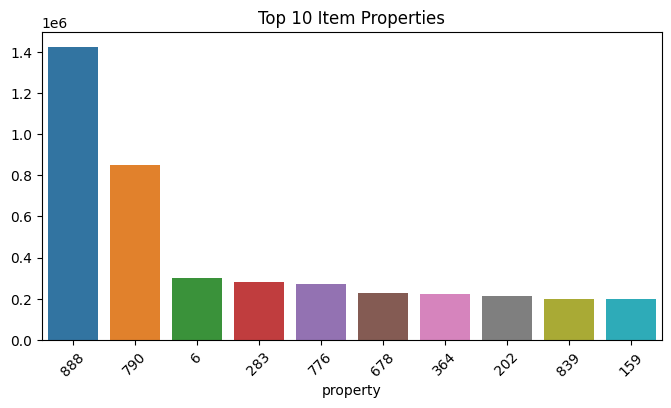

In [7]:
# Top properties
top_props = item_props["property"].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_props.index, y=top_props.values)
plt.xticks(rotation=45)
plt.title("Top 10 Item Properties")
plt.show()

# Interactive property chart
import plotly.express as px
fig = px.bar(x=top_props.index, y=top_props.values, title="Top Properties (Interactive)")
fig.show()

In [8]:
# Remove rows where property is "available" or "categoryid"
item_props = item_props[~item_props["property"].isin(["available", "categoryid"])]

print(f"Dataset shape after removal: {item_props.shape}")
print(item_props["property"].value_counts().head(10))

Dataset shape after removal: (8535899, 4)
property
888    1424935
790     848982
6       299890
283     283242
776     272834
678     229066
364     224396
202     212686
839     198356
159     198157
Name: count, dtype: int64


In [9]:
# Converting Events timestamp to datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')



In [10]:
import re

# Keep only rows where 'value' has no spaces
# and optionally matches a clean number pattern
pattern_single_value = re.compile(r'^[^\s]+$')  # no spaces

item_props = item_props[item_props['value'].apply(lambda x: bool(pattern_single_value.match(str(x))))]

print(f"Shape after removing multi-part values: {item_props.shape}")
print(item_props.head(10))

Shape after removing multi-part values: (5056162, 4)
              timestamp  itemid property    value
3   2015-05-10 03:00:00   59481      790  15360.0
4   2015-05-17 03:00:00  156781      917   828513
6   2015-06-14 03:00:00   89534      213  1121373
7   2015-05-17 03:00:00  264312        6   319724
8   2015-06-07 03:00:00  229370      202  1330310
14  2015-06-14 03:00:00  169055      790  21000.0
16  2015-06-28 03:00:00  178601      790   5400.0
17  2015-07-12 03:00:00  319291      888  1292080
21  2015-05-10 03:00:00  344365      159   519769
22  2015-06-14 03:00:00  269797      159   519769


In [11]:
# Candidate Generation
# -------------------------------
def build_user_item_matrix(events_df):
    weight_map = {"view": 1.0, "addtocart": 3.0, "transaction": 5.0}
    events_df["weight"] = events_df["event"].map(weight_map).fillna(1.0)
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    events_df["user_idx"] = user_enc.fit_transform(events_df["visitorid"])
    events_df["item_idx"] = item_enc.fit_transform(events_df["itemid"])
    rows, cols, vals = events_df["user_idx"].values, events_df["item_idx"].values, events_df["weight"].values
    ui_matrix = sparse.coo_matrix((vals, (rows, cols)),
                                  shape=(len(user_enc.classes_), len(item_enc.classes_)))
    return ui_matrix.tocsr(), user_enc, item_enc

ui_matrix, user_enc, item_enc = build_user_item_matrix(events)

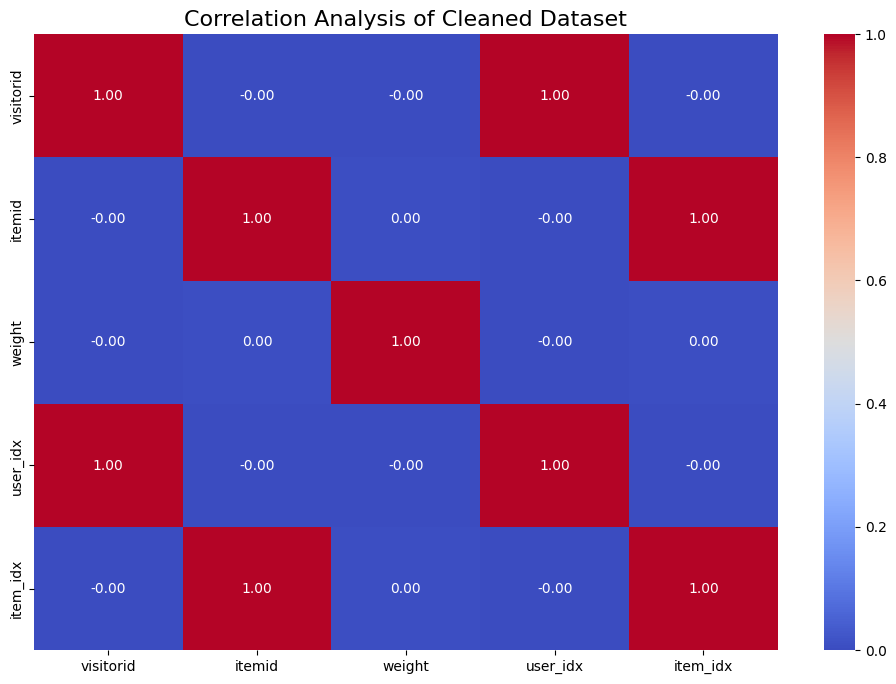

In [12]:
# Convert itemid in events to int for merging
events['itemid'] = pd.to_numeric(events['itemid'], errors='coerce')
events = events.dropna(subset=['itemid'])
events['itemid'] = events['itemid'].astype(int)


# Merge events with item properties
merged_df = events.merge(item_props, on="itemid", how="left")

# Convert 'child' column in category_tree to numeric for merging
category_tree['child'] = pd.to_numeric(category_tree['child'], errors='coerce')
category_tree = category_tree.dropna(subset=['child']) # Remove rows where conversion failed
category_tree['child'] = category_tree['child'].astype(int)

# Optionally merge with category tree if needed
merged_df = merged_df.merge(category_tree, left_on="itemid", right_on="child", how="left")

# Convert timestamp from events (which becomes timestamp_x after the first merge)
if 'timestamp_x' in merged_df.columns:
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp_x'], errors='coerce')
else:
    # Fallback to original timestamp if no merge occurred or column name is different
    merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], errors='coerce')


# Keep only numeric columns for correlation
numeric_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Drop columns with too many NaNs
numeric_df = numeric_df.dropna(axis=1, thresh=len(numeric_df) * 0.7)

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis of Cleaned Dataset", fontsize=16)
plt.show()

In [13]:
# Evaluation Metrics
# -------------------------------
def recall_at_k(true_items, pred_items, k):
    return len(set(pred_items[:k]) & set(true_items)) / max(1, len(set(true_items)))

def hit_rate_at_k(true_items, pred_items, k):
    return int(len(set(pred_items[:k]) & set(true_items)) > 0)

def ndcg_at_k(true_items, pred_items, k):
    def dcg(scores):
        return sum((2**s - 1) / np.log2(i+2) for i, s in enumerate(scores))
    rels = [1 if p in true_items else 0 for p in pred_items[:k]]
    return dcg(rels) / max(dcg(sorted(rels, reverse=True)), 1e-9)

In [14]:
# Try importing implicit (ALS)
try:
    import implicit
except ImportError:
    implicit = None

In [15]:
# Popular items baseline
def top_popular(events_df, k=10):
    return events_df["itemid"].value_counts().head(k).index.tolist()

print("Top popular items:", top_popular(events, 10))

Top popular items: [187946, 5411, 370653, 461686, 298009, 96924, 219512, 384302, 335975, 441668]


In [16]:
# -------------------------------
# Task 1 - Deep Learning Model (Tuned CNN Only)
# -------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import Counter

# --- Step 1: Prepare data ---
target_prop = item_props["property"].value_counts().index[0]
print("Target property for prediction:", target_prop)

# Build item->latest value for target_prop
prop_df = item_props[item_props["property"] == target_prop].sort_values("timestamp")
item_latest_prop = prop_df.groupby("itemid")["value"].last().to_dict()

X_texts, y_labels = [], []
for _, row in events[events["event"] == "addtocart"].iterrows():
    user_hist = events[(events["visitorid"] == row["visitorid"]) &
                       (events["timestamp"] < row["timestamp"]) &
                       (events["event"] == "view")]
    tokens = [str(item_latest_prop.get(i, "")) for i in user_hist["itemid"].values]
    label = item_latest_prop.get(row["itemid"])
    if label and tokens:
        X_texts.append(" ".join(tokens))
        y_labels.append(label)

# Filter to frequent classes only (adaptive min frequency)
counts = Counter(y_labels)
min_freq = 10  # lower to keep more classes for small samples
top_classes = {cls for cls, cnt in counts.items() if cnt >= min_freq}
filtered = [(txt, lbl) for txt, lbl in zip(X_texts, y_labels) if lbl in top_classes]

if not filtered:
    print("No training samples found after filtering.")
else:
    X_texts, y_labels = zip(*filtered)
    X_texts, y_labels = list(X_texts), list(y_labels)

    # Encode labels
    label_enc = LabelEncoder()
    y_enc = label_enc.fit_transform(y_labels)
    num_classes = len(label_enc.classes_)

    # Tokenize & pad sequences
    max_words = 5000
    max_len = 50
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_texts)
    X_seq = tokenizer.texts_to_sequences(X_texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    # Train/test split
    X_train, X_val, y_train, y_val = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

    # Convert to categorical
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    # --- Step 2: Define Tuned CNN ---
    def build_cnn():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(max_words, 128, input_length=max_len),
            tf.keras.layers.Conv1D(256, 5, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(128, 5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=['accuracy']
        )
        return model

    # --- Step 3: Train CNN ---
    cnn_model = build_cnn()
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    history = cnn_model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=8,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1
    )

    # --- Step 4: Evaluate ---
loss, acc = cnn_model.evaluate(X_val, y_val_cat, verbose=0)
print(f"\nModel Evaluation:")
print(f"Validation Loss:     {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

# --- Step 5: Precision, Recall, F1 ---
y_pred_probs = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_val, y_pred, average="weighted")
recall = recall_score(y_val, y_pred, average="weighted")
f1 = f1_score(y_val, y_pred, average="weighted")

print("\nClassification Metrics (Weighted):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# --- Step 6: Detailed per-class report (optional) ---
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_enc.classes_))


2025-09-18 21:20:33.701548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758230434.023515      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758230434.115463      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Target property for prediction: 790


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.

2025-09-18 22:15:39.085261: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.0113 - loss: 5.6195 - val_accuracy: 0.0213 - val_loss: 5.6216
Epoch 2/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.0505 - loss: 5.3052 - val_accuracy: 0.1238 - val_loss: 5.5372
Epoch 3/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.2182 - loss: 3.9048 - val_accuracy: 0.5614 - val_loss: 5.2204
Epoch 4/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6447 - loss: 1.9598 - val_accuracy: 0.8420 - val_loss: 4.6554
Epoch 5/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8317 - loss: 1.0669 - val_accuracy: 0.8634 - val_loss: 4.0735
Epoch 6/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8770 - loss: 0.7240 - val_accuracy: 0.8677 - val_loss: 3.3739
Epoch 7/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.8949 - loss: 0.6303 - val_accuracy: 0.8709 - val_loss: 2.6005
Epoch 8/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9173 - loss: 0.5170 - val_accuracy: 0.8666 - val_loss

NameError: name 'precision_score' is not defined

In [17]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

    # --- Step 4: Evaluate ---
loss, acc = cnn_model.evaluate(X_val, y_val_cat, verbose=0)
print(f"\nModel Evaluation:")
print(f"Validation Loss:     {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

# --- Step 5: Precision, Recall, F1 ---
y_pred_probs = cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

precision = precision_score(y_val, y_pred, average="weighted")
recall = recall_score(y_val, y_pred, average="weighted")
f1 = f1_score(y_val, y_pred, average="weighted")

print("\nClassification Metrics (Weighted):")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# --- Step 6: Detailed per-class report (optional) ---
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_enc.classes_))



Model Evaluation:
Validation Loss:     1.8915
Validation Accuracy: 0.8666
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Classification Metrics (Weighted):
Precision: 0.8915
Recall:    0.8666
F1-Score:  0.8663

Detailed Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



ValueError: Number of classes, 267, does not match size of target_names, 279. Try specifying the labels parameter

In [ ]:
# --- Task 1: Save CNN Recommender Artifacts ---
import json
import pickle

# Save tokenizer
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(json.dumps(json.loads(tokenizer_json)))

# Save label encoder
with open("labelencoder.pkl", "wb") as f:
    pickle.dump(label_enc, f)

print("✅ Task 1 artifacts saved: cnn_model.h5, tokenizer.json, labelencoder.pkl")

In [19]:
import shutil

# Zip all artifacts
shutil.make_archive("artifacts", 'zip', "/kaggle/working")

# Check if zip created
import os
print(os.listdir("/kaggle/working"))


RuntimeError: File size too large, try using force_zip64

In [20]:
# Task 2 - Abnormal User Detection (CNN Autoencoder + Visualization)
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# --- Step 1: Build user-level features ---
def build_user_features(events_df):
    feats = []
    for uid, g in events_df.groupby("visitorid"):
        total = len(g)
        views = (g["event"] == "view").sum()
        adds = (g["event"] == "addtocart").sum()
        buys = (g["event"] == "transaction").sum()
        feats.append({
            "visitorid": uid,
            "total_events": total,
            "views": views,
            "adds": adds,
            "buys": buys,
            "add_rate": adds/total if total > 0 else 0,
            "conv_rate": buys/total if total > 0 else 0
        })
    return pd.DataFrame(feats).set_index("visitorid")

user_feats = build_user_features(events)

# --- Step 2: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_feats)

# Reshape for CNN (samples, timesteps, channels)
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# --- Step 3: Define CNN Autoencoder ---
def build_cnn_autoencoder(seq_len):
    input_layer = tf.keras.layers.Input(shape=(seq_len, 1))
    x = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling1D(2, padding='same')(x)
    x = tf.keras.layers.Conv1D(16, 2, activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 2, activation='relu', padding='same')(x)
    decoded = tf.keras.layers.Conv1D(1, 2, activation='linear', padding='same')(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

cnn_autoencoder = build_cnn_autoencoder(X_cnn.shape[1])

# --- Step 4: Train autoencoder ---
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = cnn_autoencoder.fit(
    X_cnn, X_cnn,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# --- Step 5: Reconstruction error ---
reconstructions = cnn_autoencoder.predict(X_cnn)
mse = np.mean(np.power(X_cnn - reconstructions, 2), axis=(1, 2))
threshold = np.percentile(mse, 98)  # top 2% anomaly threshold

user_feats["reconstruction_error"] = mse
user_feats["outlier"] = (mse > threshold).astype(int)
print(f"Detected outliers: {user_feats['outlier'].sum()} users")

Epoch 1/20
34510/34510 ━━━━━━━━━━━━━━━━━━━━ 128s 4ms/step - loss: 0.0432 - val_loss: 1.6093e-04
Epoch 2/20
34510/34510 ━━━━━━━━━━━━━━━━━━━━ 125s 4ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 3/20
34510/34510 ━━━━━━━━━━━━━━━━━━━━ 132s 4ms/step - loss: 0.0024 - val_loss: 4.0292e-04
43138/43138 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step
Detected outliers: 25085 users


In [ ]:
# --- Task 2: Save CNN Autoencoder Artifacts ---
import pickle

# Save CNN Autoencoder model
cnn_autoencoder.save("cnn_ae.h5")

# Save scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Task 2 artifacts saved: cnn_ae.h5, scaler.pkl")